In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split 



def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    
    return conv
    


nx=128
nz=40
nchannels=6

def UNetCompiled(nx, nz, nchannels, n_filters=8, nchannels_out=3):
   """
   Combine both encoder and decoder blocks according to the U-Net research paper
   Return the model as output 
   """
   input_size=(nx, nz, nchannels)

    # Input size represent the size of 1 image (the size used for pre-processing) 
   inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
   cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
   cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
   cblock3 = EncoderMiniBlock(cblock2[0],n_filters*4,dropout_prob=0.2, max_pooling=True)
   cblock4 = EncoderMiniBlock(cblock3[0],n_filters*4,dropout_prob=0.2, max_pooling=False)

   ublock5 = DecoderMiniBlock(cblock4[0], cblock3[1],  n_filters * 4)
   ublock6 = DecoderMiniBlock(ublock5, cblock2[1],  n_filters * 4)
   ublock7 = DecoderMiniBlock(ublock6, cblock1[1],  n_filters * 2)

   conv10 = Conv2D(nchannels_out,3, padding='same')(ublock7)


   model = tf.keras.Model(inputs=inputs, outputs=conv10)

   return model


In [31]:
import netCDF4 as nc
compLev=5
#ds.to_netcdf('gce2d.nc',encoding={'qr':{'zlib':True,'complevel':compLev},'qs':{'zlib':True,'complevel':compLev},'dqv':{'zlib':True,'complevel':compLev},'dpt':{'zlib':True,'complevel':compLev},'qva':{'zlib':True,'complevel':compLev},'ta':{'zlib':True,'complevel':compLev},'u':{'zlib':True,'complevel':compLev},'v':{'zlib':True,'complevel':compLev},'w':{'zlib':True,'complevel':compLev},'p0':{'zlib':True,'complevel':compLev},'lh':{'zlib':True,'complevel':compLev},'pi':{'zlib':True,'complevel':compLev}})
with nc.Dataset('gce2d.nc') as ds:
    qr=ds['qr'][:]
    qs=ds['qs'][:]
    qg=ds['qg'][:]
    dqv=ds['dqv'][:]
    dpt=ds['dpt'][:]
    qva=ds['qva'][:]
    ta=ds['ta'][:]
    u=ds['u'][:]
    v=ds['v'][:]
    w=ds['w'][:]
    p0=ds['p0'][:]
    lh=ds['lh'][:]
    pi=ds['pi'][:]


In [38]:
import numpy as np
xL=[]
yL=[]
for i in range(100,2900):
    qv=dqv[i,:,:]+qva[i]
    pt=dpt[i,:,:]+ta[i]
    qv1=dqv[i+1,:,:]+qva[i+1]
    pt1=dpt[i+1,:,:]+ta[i+1]
    #print(pi[i])
    tK=pt*pi[i]
    tK1=pt1*pi[i+1]
    #print(tK[0,:])
    #print(qv[0,:])
    
    for irep in range(20):
        istart=np.random.randint(0,510-128)
        yL.append(np.stack([(tK1[istart:istart+128,:40]-273)/10.,qv1[istart:istart+128,:40]/6e-3,\
                            np.log10(1+qr[i+1,istart:istart+128,:40]/1e-4),np.log10(1+qs[i+1,istart:istart+128,:40]/1e-4),\
                            np.log10(1+qg[i+1,istart:istart+128,:40]/1e-4)],axis=2))
        xL.append(np.stack([u[i,istart:istart+128,:40]/10,v[i,istart:istart+128,:40]/10,w[i,istart:istart+128,:40]/10,\
                            (tK[istart:istart+128,:40]-273)/10,qv[istart:istart+128,:40]/6e-3,\
                            np.log10(1+qr[i,istart:istart+128,:40]/1e-4),np.log10(1+qs[i,istart:istart+128,:40]/1e-4),\
                            np.log10(1+qg[i,istart:istart+128,:40]/1e-4)],axis=2))
    #break

xL=np.array(xL)
yL=np.array(yL)
print(xL.shape)
print(yL.shape)

(56000, 128, 40, 8)
(56000, 128, 40, 5)


In [39]:
xL=np.array(xL)
yL=np.array(yL)
print(xL.shape)
print(yL.shape)
import numpy as np
istart=np.random.randint(0,510-128)
#print(istart)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(xL, yL, test_size=0.2, random_state=42)


(56000, 128, 40, 8)
(56000, 128, 40, 5)


In [40]:
nx=128
nz=40
nchannels=8
nchannels_out=5
unet_moisture=UNetCompiled(nx, nz, nchannels, n_filters=8, nchannels_out=nchannels_out)
unet_moisture.compile(optimizer='adam', loss='mse', metrics=['mse'])


In [41]:
history=unet_moisture.fit(x_train, y_train[:,:,:,:], epochs=10, batch_size=32,validation_data=(x_test, y_test[:,:,:,:]))

Epoch 1/10
1400/1400 [==============================] - 229s 162ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 2/10
1400/1400 [==============================] - 225s 160ms/step - loss: 9.5257e-04 - mse: 9.5257e-04 - val_loss: 7.6071e-04 - val_mse: 7.6071e-04
Epoch 3/10
1400/1400 [==============================] - 225s 161ms/step - loss: 6.6405e-04 - mse: 6.6405e-04 - val_loss: 4.9034e-04 - val_mse: 4.9034e-04
Epoch 4/10
1400/1400 [==============================] - 223s 159ms/step - loss: 5.3344e-04 - mse: 5.3344e-04 - val_loss: 4.1316e-04 - val_mse: 4.1316e-04
Epoch 5/10
1400/1400 [==============================] - 224s 160ms/step - loss: 4.4339e-04 - mse: 4.4339e-04 - val_loss: 6.5008e-04 - val_mse: 6.5008e-04
Epoch 6/10
1400/1400 [==============================] - 224s 160ms/step - loss: 3.8159e-04 - mse: 3.8159e-04 - val_loss: 3.0808e-04 - val_mse: 3.0808e-04
Epoch 7/10
1400/1400 [==============================] - 225s 160ms/step - loss: 3.3702e-04 -

In [42]:
unet_moisture.save('unet_moisture_gce2d.h5')
unet_moisture.save('unet_moisture_gce2d.keras')
grid=np.loadtxt('grid_def.txt')
z=[-80]
z.extend(grid[:,-3][::-1])

/Users/mgrecu/miniconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


(1, 128, 40, 8)
1/1 [==============================] - 0s 14ms/step


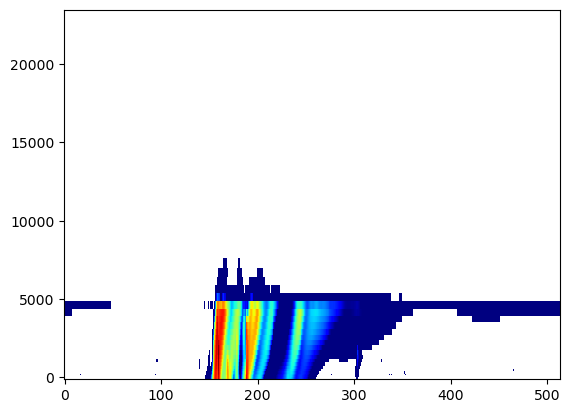

In [43]:
import matplotlib.pyplot as plt
import matplotlib
plt.pcolormesh(range(514),z,qr[420,:,:].T,norm=matplotlib.colors.LogNorm(vmin=1e-5),cmap='jet')

x_m_test_=[]
y_m_test_=[]
for i in range(420,436):
    istart=128
    qv=dqv[i,:,:]+qva[i]
    pt=dpt[i,:,:]+ta[i]
    qv1=dqv[i+1,:,:]+qva[i+1]
    pt1=dpt[i+1,:,:]+ta[i+1]
    #print(pi[i])
    tK=pt*pi[i]
    tK1=pt1*pi[i+1]
    y_m_test_.append(np.stack([(tK1[istart:istart+128,:40]-273)/10.,qv1[istart:istart+128,:40]/6e-3,\
                            np.log10(1+qr[i+1,istart:istart+128,:40]/1e-4),np.log10(1+qs[i+1,istart:istart+128,:40]/1e-4),
                            np.log10(1+qg[i+1,istart:istart+128,:40]/1e-4)],axis=2))
    x_m_test_.append(np.stack([u[i,istart:istart+128,:40]/10,v[i,istart:istart+128,:40]/10,w[i,istart:istart+128,:40]/10,\
                            (tK[istart:istart+128,:40]-273)/10,qv[istart:istart+128,:40]/6e-3,\
                            np.log10(1+qr[i,istart:istart+128,:40]/1e-4),np.log10(1+qs[i,istart:istart+128,:40]/1e-4),
                            np.log10(1+qg[i,istart:istart+128,:40]/1e-4)],axis=2))   

y_np_L=[]
x_m_test_=np.array(x_m_test_)
y_m_test_=np.array(y_m_test_)
x_=np.array(x_m_test_)[0:1]
print(x_.shape)
for i in range(15):
    y_=unet_moisture.predict(x_)
    #print(y_.shape)
    x_=x_m_test_[i+1:i+2,:,:,:].copy()
    
    x_[0,:,:,3:]=y_[0,:,:,:]
    y_np_L.append(y_[0])
    #x_=y_

(15, 128, 40, 5)
0.9634079905912205
0.8880242813680205
0.8405131886392807
0.8371057171430444
0.8213093975119578


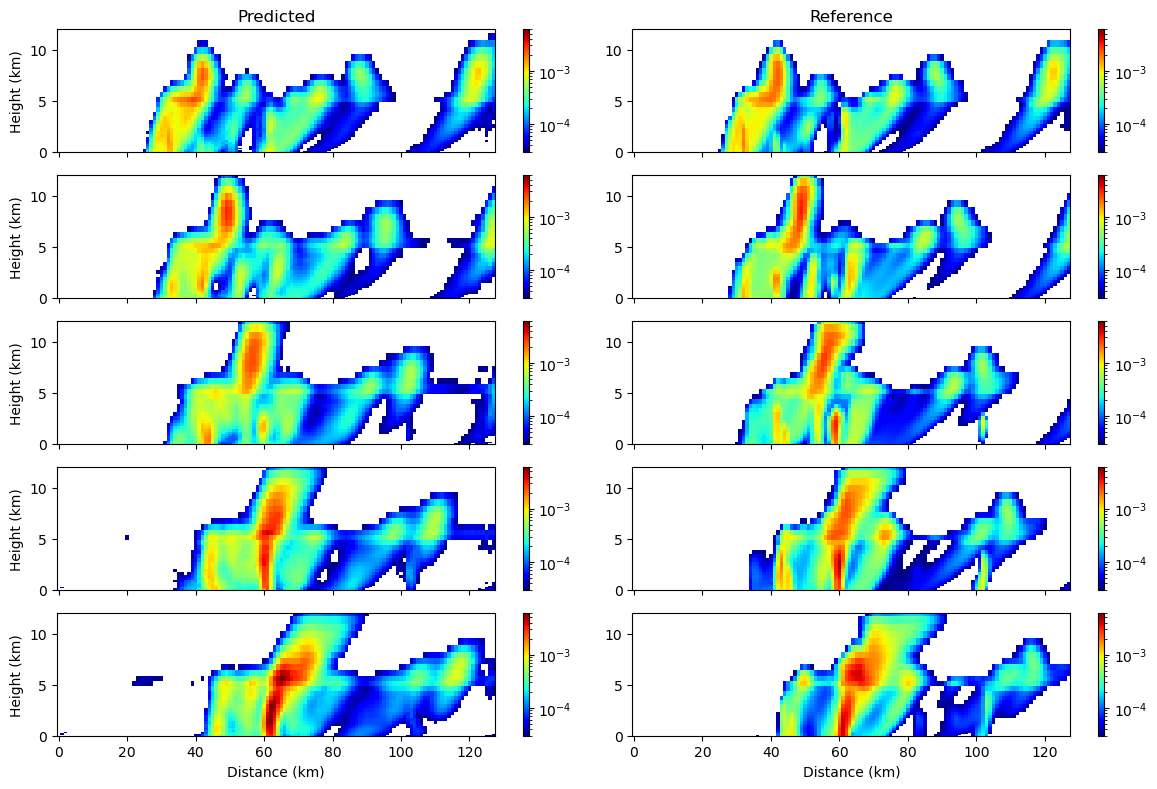

In [49]:
y_np=np.array(y_np_L)
y_test_real=np.array(y_m_test_)
print(y_np.shape)
plt.figure(figsize=(12,8))


for i in range(0,15,3):
    i3=int(i/3)
    ax1=plt.subplot(5,2,2*i3+1)

    qfr_pred=(10**(y_np[i,:,:,3])-1)*1e-4+(10**(y_np[i,:,:,4])-1)*1e-4
    qr_pred=(10**(y_np[i,:,:,2])-1)*1e-4
    qtot_pred=qfr_pred+qr_pred
    qtot_predm=np.ma.array(qtot_pred,mask=qtot_pred<3e-5)
    plt.pcolormesh(np.arange(128)*1,np.array(z[:40])/1e3,qtot_predm.T,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=3e-5,vmax=6e-3))
    plt.ylim(0,12)
    plt.colorbar()
    #plt.xlim(40/2,80/2)
    ax2=plt.subplot(5,2,2*i3+2)
    qfr_real=(10**(y_test_real[i,:,:,3])-1)*1e-4+(10**(y_test_real[i,:,:,4])-1)*1e-4
    qr_real=(10**(y_test_real[i,:,:,2])-1)*1e-4
    qtot_real=qfr_real+qr_real
    qtot_realm=np.ma.array(qtot_real,mask=qtot_real<3e-5)
    plt.pcolormesh(np.arange(128)*1,np.array(z[:40])/1e3,qtot_realm.T,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=3e-5,vmax=6e-3))
    plt.ylim(0,12)
    plt.colorbar()
    if i3<4:
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])
    #plt.xlim(40/2,80/2)
    ax1.set_ylabel('Height (km)')
    if i3==4:
        ax1.set_xlabel('Distance (km)')
        ax2.set_xlabel('Distance (km)')
    if i3==0:
        ax1.set_title('Predicted')
        ax2.set_title('Reference')
    print(np.corrcoef(y_np[i,:,:,3].flatten(),y_test_real[i,:,:,3].flatten())[0,1])
plt.tight_layout()
plt.savefig('unet_hyd_prediction.png',dpi=300)